In [1]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
import torch.optim as optim
import random
import copy
import sys
from torch.nn import functional as F
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [6]:
def createDictFloor(floor_idx,path):
    floorname = [f'Floor{idx}' for idx in floor_idx]
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for name in floorname for floor in fulldata if name in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def createDTFeat(date1, date2, datadict,featureX,resample_method_X="mean"):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        elif resample_method_X == "max":
            dataX = dataX.resample("5T").max().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["weekday"] = resample_move[floorname].index.weekday
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
        
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates

def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = copy.deepcopy(datadict)
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(scaled_data_dict[floorname][feature])
        scaled_data_dict[floorname][feature] = scaler.transform(scaled_data_dict[floorname][feature])
        scalers[floorname] = scaler
        
        #dummies_floor = pd.get_dummies(scaled_data_dict[floorname]["weekday"])
        #scaled_data_dict[floorname] = pd.concat([scaled_data_dict[floorname],dummies_floor], axis=1)

    return scaled_data_dict, scalers

def get_info_timeshape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [7]:
def get_info_zone(datadict):
    for data in datadict.keys():
        zone = datadict[data]
        print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
        print("")

In [48]:
seed_everything()
date1 = "2019-03-07"
date2 = "2019-09-29"
floors = [5,6,7]
floor_dict = createDictFloor(floors, bkdatafolder)
feature = ["temperature"]
resample_method = "mean"
resample,remain_date = createDTFeat(date1, date2, floor_dict, feature,resample_method_X=resample_method)
scaled_data, scalers = data_scaling(resample, feature)

In [49]:
def distribution(datadict, feature):
    zone_list = sorted(list(datadict.keys()))
    concat_feature = pd.DataFrame()
    for zone in zone_list:
        concat_feature = pd.concat([concat_feature, datadict[zone][feature].rename(f"{zone}")],axis=1)
    return concat_feature

In [50]:
to_distribution = distribution(resample, "temperature")

<AxesSubplot:>

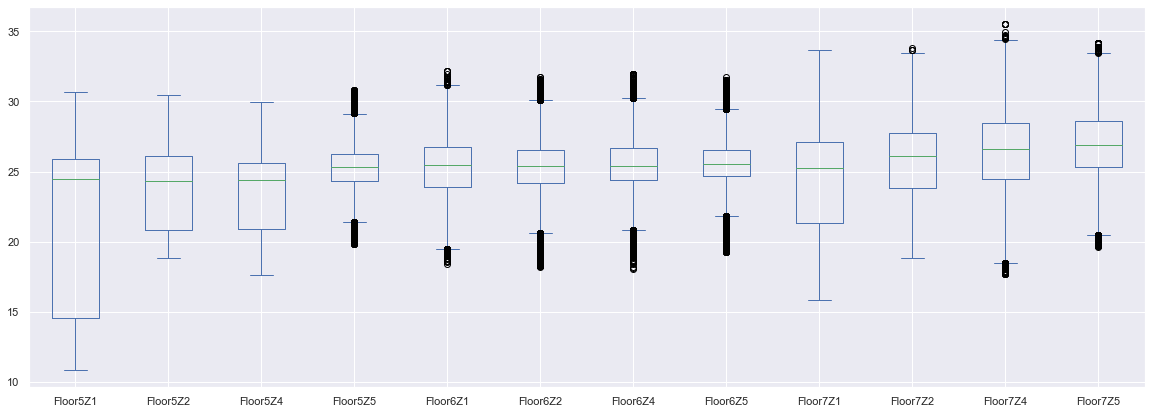

In [51]:
to_distribution.plot(kind="box", figsize=(20,7))

In [52]:
mask1 = scaled_data["Floor7Z1"]["weekday"].values ==5
mask2 = scaled_data["Floor7Z1"]["weekday"].values ==6

In [53]:
get_info_zone(scaled_data)

Floor5Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616



In [54]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Create Slice

In [55]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            arraydata = datadict[floor].loc[date][features]
            databyDate[date][floor] = np.asarray(arraydata)#np.asarray(datadict[floor].loc[date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False, noise=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(trainy, dtype=torch.float).squeeze(-1)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

In [56]:
cutting_date = "2019-04-20"
train_date, test_date = splitDate(remain_date, cutting_date)
#featureplus = ["temperature"]
databyDate = createDataByDate(scaled_data, feature,remain_date)

In [57]:
lookback = 13
lookahead = 1
batch_size = 32

In [58]:
zones = [i for i in range(5,0,-1) if i!=3]

In [60]:
zones

[5, 4, 2, 1]

In [61]:
def get_loader(floor_list,datadates, train_date, test_date, lookback, lookahead, batch_size):
    trainloader, testloader = [], []
    nb_zone = 5#*len(floor_list)
    zones = [i for i in range(1,nb_zone+1) if i!=3]
    zones_id = []
    for floor in floor_list:
        for zone in zones:
            zoneID = f'Floor{floor}Z{zone}'
            zones_id.append(zoneID)
    #random.shuffle(zones_id)
    for zone in zones_id:#range(1,nb_zone+1):
            print(f'-----{zone}-----')
            loaderZtrain = LoaderByZone(datadates,zone,train_date,lookback,lookahead,batch_size, shuffle=True)
            loaderZtest = LoaderByZone(datadates,zone,test_date,lookback, lookahead,batch_size, shuffle=False)
            trainloader.append(loaderZtrain)
            testloader.append(loaderZtest)
            #zones_id.append(zoneID)
    return trainloader, testloader, zones_id

In [62]:
trainloader, testloader, zone_id = get_loader(floors, databyDate, train_date, test_date, lookback, lookahead, batch_size)

-----Floor5Z1-----
-----Floor5Z2-----
-----Floor5Z4-----
-----Floor5Z5-----
-----Floor6Z1-----
-----Floor6Z2-----
-----Floor6Z4-----
-----Floor6Z5-----
-----Floor7Z1-----
-----Floor7Z2-----
-----Floor7Z4-----
-----Floor7Z5-----


In [63]:
x, y = iter(trainloader[0]["2019-03-08"]).next()

In [64]:
x.shape, y.shape

(torch.Size([32, 13, 1]), torch.Size([32, 1]))

In [65]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

360

# Algorithm

In [66]:
def proj_2shape(x,s=8):
    shape = x.shape
    if torch.linalg.norm(x,ord=1)==s and torch.all(x>0):
        return x
    u,_ = torch.sort(torch.abs(x),dim=0,descending=True)
    cumsum = torch.cumsum(u, dim=0)
    arange = torch.arange(1, shape[0]+1)
    rep_arange = arange.unsqueeze(1).repeat(1,shape[1])
    rho = torch.count_nonzero((u*rep_arange > (cumsum - s)), dim=0)
    theta = (cumsum[rho-1, torch.arange(0,shape[1])] - s)/rho
    proj = (torch.abs(x)-theta).clamp(min=0)
    proj*= torch.sign(x)
    return proj

def proj_l1(x, s=8):
    shape = x.shape
    if len(shape) == 4:
        proj = torch.zeros_like(x)
        for first_dim in range(x.shape[0]):
            for second_dim in range(x.shape[1]):
                inner_tensor = x[first_dim][second_dim]
                inner_proj = proj_2shape(inner_tensor,s=s)
                proj[first_dim][second_dim] = inner_proj
                
    elif len(shape) == 3:
        proj = torch.zeros_like(x)
        for first_dim in range(x.shape[0]):
            inner_tensor = x[first_dim]
            inner_proj = proj_2shape(inner_tensor,s=s)
            proj[first_dim] = inner_proj
        
    elif len(shape) == 2:
        proj = proj_2shape(x,s=s)
        
    elif len(shape) == 1:
        u,_ = torch.sort(torch.abs(x),descending=True)
        cumsum = torch.cumsum(u,dim=0)
        arange = torch.arange(1,shape[0]+1)
        rho = torch.count_nonzero((u*arange > (cumsum - s)))
        theta = (cumsum[rho-1] - s)/rho
        proj = (torch.abs(x)-theta).clamp(min=0)
        proj*= torch.sign(x)
    return proj

In [67]:
def simpleLMO(x,radius,p=1):
    tolerance = 1e-10
    if p == 1:
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
        return v
    elif p == 2:
        x_norm = float(torch.norm(x, p=2))
        if x_norm > tolerance:
            return -radius * x.div(x_norm)
        else:
            return torch.zeros_like(x)
    elif p == float('inf'):
        return torch.full_like(x, fill_value=radius).masked_fill_(x > 0, -radius)

def simpleProject(x,radius,p=1):
    if p==1:
        x_norm = torch.linalg.norm(x, ord=1)
        if x_norm > radius:
            sorted_ = torch.sort(torch.abs(x.flatten()), descending=True).values
            running_mean = (torch.cumsum(sorted_, 0) - radius)/torch.arange(1,sorted_.numel() + 1)                                                                                  
            is_less_or_equal = sorted_ <= running_mean
            idx = is_less_or_equal.numel() - is_less_or_equal.sum() - 1
            return torch.sign(x) * torch.max(torch.abs(x) - running_mean[idx], torch.zeros_like(x))
        else:
            return x
    elif p == 2:
        x_norm = torch.linalg.norm(x, ord=2)
        return radius * x.div(x_norm) if x_norm > radius else x
    elif p == float('inf'):
        return torch.clamp(x, min=-radius, max=radius)
def simpleProject_3D(x, radius):
    shape = x.shape
    if len(shape) == 3:
        proj = torch.zeros_like(x)
        for first_dim in range(x.shape[0]):
            inner_tensor = x[first_dim]
            inner_proj = simpleProject(inner_tensor,radius)
            proj[first_dim] = inner_proj
        
    elif len(shape) == 2 or len(shape)==1:
        proj = simpleProject(x,radius)
    return proj

In [68]:
def lmo(x,radius):
    """Returns v with norm(v, self.p) <= r minimizing v*x"""
    shape = x.shape
    if len(shape) == 4:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            for second_dim in range(shape[1]):
                inner_x = x[first_dim][second_dim]
                rows, cols = x[first_dim][second_dim].shape
                v[first_dim][second_dim] = torch.zeros_like(inner_x)
                maxIdx = torch.argmax(torch.abs(inner_x),0)
                for col in range(cols):
                    v[first_dim][second_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
    elif len(shape) == 3:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            inner_x = x[first_dim]
            rows, cols = x[first_dim].shape
            v[first_dim] = torch.zeros_like(inner_x)
            maxIdx = torch.argmax(torch.abs(inner_x),0)
            for col in range(cols):
                v[first_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
                    
    elif len(shape)==2:
        rows, cols = x.shape
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x),0)
        for col in range(cols):
            v[maxIdx[col],col] = -radius*torch.sign(x[maxIdx[col],col])
                
    else : 
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
    return v

In [69]:
class DMFW(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, L=required, matrix_line=required, reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp == 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp,L=L, matrix_line=matrix_line,reg_coef = reg_coef,radius=radius)
        super(DMFW,self).__init__(params,defaults)

        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.reg_coef = group["reg_coef"]
            self.A = group["matrix_line"]
            self.L = group["L"]
            self.radius = group["radius"]
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.G = [[torch.rand(k) for k in self.dim] for l in range(self.L)]
        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            for k,weight in enumerate(group["params"]):
                #print(k, weight.shape)
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                
    def neighborsAverage(self, neighbors):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                weighted_tmp = torch.zeros(self.dim[k])
                weighted_grad_tmp = torch.zeros(self.dim[k])
                for j in range(len(neighbors)):
                    weighted_tmp += self.A[j]*neighbors[j].w_dict[k]["w"]
                    weighted_grad_tmp += self.A[j]*neighbors[j].w_dict[k]["g"]
                self.w_dict[k]["y"] = weighted_tmp
                self.w_dict[k]["ds"] = weighted_grad_tmp


    def step(self, l, closure):
        if l == 0:
            self.init_gap = 0
        eta = min(self.eta_coef/(l+1)**self.eta_exp, 1)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            self.gap = 0
            for k,weight in enumerate(group["params"]):
                a = lmo(weight.grad.data,self.radius)
                self.gap += torch.sum(torch.mul(weight.grad.data, weight.data - a))
                #v = proj_l1(self.G[l][k], self.radius)
                v = lmo(self.G[l][k] - 0.5 + torch.rand_like(self.G[l][k]), radius= self.radius)
                if weight.grad is None:
                    raise ValueError("Grad is None")
                self.w_dict[k]["grad_old"] = weight.grad.detach().clone()
                
                weight.data = self.w_dict[k]['y']*(1-eta) + eta*v
                #print("weight {}".format(torch.linalg.norm(weight.data,ord=1,dim=0)))
                self.w_dict[k]["w"] = weight.detach().clone()
                
            self.init_gap += self.gap
            self.init_gap /= (l+1)
            
            with torch.enable_grad():
                closure()
            for k,weight in enumerate(group["params"]):
                #self.G[l][k] -= 0.5*self.w_dict[k]["ds"]*self.reg_coef
                #self.G[l][k] -= self.w_dict[k]["ds"]*self.reg_coef
                self.G[l][k] += self.w_dict[k]["ds"]*self.reg_coef
                if weight.grad is None :
                    raise ValueError("Grad is none")
                weight.grad.add_(-self.w_dict[k]["grad_old"])
                self.w_dict[k]["g"] = weight.grad.detach().clone() + self.w_dict[k]["ds"]

In [70]:
class SDMFW(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, L=required, matrix_line=required, reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp == 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp,L=L, matrix_line=matrix_line,reg_coef = reg_coef,radius=radius)
        super(SDMFW,self).__init__(params,defaults)

        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.reg_coef = group["reg_coef"]
            self.A = group["matrix_line"]
            self.L = group["L"]
            self.radius = group["radius"]
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.G = [[torch.rand(k) for k in self.dim] for l in range(self.L)]
        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            for k,weight in enumerate(group["params"]):
                #print(k, weight.shape)
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                self.w_dict[k]["as"] = torch.randn_like(weight)
                
    def neighborsAverage(self, neighbors):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                weighted_tmp = torch.zeros(self.dim[k])
                weighted_grad_tmp = torch.zeros(self.dim[k])
                for j in range(len(neighbors)):
                    weighted_tmp += self.A[j]*neighbors[j].w_dict[k]["w"]
                    weighted_grad_tmp += self.A[j]*neighbors[j].w_dict[k]["g"]
                self.w_dict[k]["y"] = weighted_tmp
                self.w_dict[k]["ds"] = weighted_grad_tmp


    def step(self, l, closure):
        if l == 0:
            self.init_gap = 0
        eta = min(self.eta_coef/(l+1)**self.eta_exp, 1)
        rho_l = (2/(l+3))**(2/3)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            self.gap = 0
            for k,weight in enumerate(group["params"]):
                a = lmo(weight.grad.data,self.radius)
                self.gap += torch.sum(torch.mul(weight.grad.data, weight.data - a))
                #v = proj_l1(self.G[l][k], self.radius)
                v = lmo(self.G[l][k] - 0.5 + torch.rand_like(self.G[l][k]), radius= self.radius)
                if weight.grad is None:
                    raise ValueError("Grad is None")
                self.w_dict[k]["grad_old"] = weight.grad.detach().clone()
                
                weight.data = self.w_dict[k]['y']*(1-eta) + eta*v
                #print("weight {}".format(torch.linalg.norm(weight.data,ord=1,dim=0)))
                self.w_dict[k]["w"] = weight.detach().clone()
                
            self.init_gap += self.gap
            self.init_gap /= (l+1)
            
            with torch.enable_grad():
                closure()
            for k,weight in enumerate(group["params"]):
                #self.G[l][k] -= 0.5*self.w_dict[k]["ds"]*self.reg_coef
                #self.G[l][k] -= self.w_dict[k]["ds"]*self.reg_coef
                self.w_dict[k]["as"] = (1-rho_l)*self.w_dict[k]["as"] + rho_l*self.w_dict[k]["ds"]
                self.G[l][k] += self.w_dict[k]["as"]*self.reg_coef
                if weight.grad is None :
                    raise ValueError("Grad is none")
                weight.grad.add_(-self.w_dict[k]["grad_old"])
                self.w_dict[k]["g"] = weight.grad.detach().clone() + self.w_dict[k]["ds"]
                

In [71]:
class Trainer:
    def __init__(self, graph, loaders, model, model_param, loss,
                 num_iterations):
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 4),
                                     dtype='float')

        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes

    def reset(self):
        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.] * self.num_nodes
        self.best_models = [0.]*self.num_nodes

        self.obj_values = np.ndarray((self.num_iterations + 1, 4),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes
    
    def initModelWeight(self, model):
        for m in model.modules():
            if isinstance(m, nn.LSTM):
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data,0)
            elif isinstance(m,nn.BatchNorm1d):
                nn.init.uniform_(m.weight.data)
                nn.init.constant_(m.bias.data,0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.uniform_(m.bias.data)
                #nn.init.constant_(m.bias.data,0)


    def saveCheckPts(self, t, path):
        check_pts = {}
        for i in range(self.num_nodes):
            ckp_i = {
                "t": t,
                "weight": [param for param in self.models[i].parameters()],
                "optimizer_weight": self.optimizers[i].w_dict,
                "oracles": self.optimizers[i].G,
                "loss": self.losses[i]
            }  #,
            #"avg_loss": self.avg_loss[i]}
            check_pts[i] = ckp_i
        torch.save(check_pts, path + "checkpts_models" + "_" + str(t) + ".tar")
        
    def plotPrediction(self, true, pred,date,path_to_save):
        fig = plt.figure(figsize=(5,3))
        plt.suptitle("{}".format(date))
        plt.plot(true)
        plt.plot(pred)
        #plt.show()
        fig.savefig(os.path.join(path_to_save,date))
        plt.close()

    def train(self, optimizer, L, eta_coef, eta_exp, reg_coef, radius, path_figure_date, print_freq, dates):
        seed_everything()
        self.reset()

        for i in range(self.num_nodes):
            self.models[i] = self.model(*self.param)
            self.optimizers[i] = optimizer(self.models[i].parameters(),
                                           eta_coef=eta_coef,
                                           eta_exp=eta_exp,
                                           L=L,
                                           matrix_line=self.A[i],
                                           reg_coef=reg_coef,
                                           radius=radius)
            self.best_models[i] = copy.deepcopy(self.models[i])

        self.final_gap = [0.] * self.num_nodes
        
        t = 0
        
        for date in dates:
            
            try:
                for i in range(self.num_nodes):
                    truez, predz = ModelPrediction(self.best_models[i], date, self.dataloader[i],lookahead)
                    path = path_figure_date+"/Model_"+str(i)+"/"
                    if not os.path.exists(path):
                        os.makedirs(path)
                    self.plotPrediction(truez, predz,date,path_to_save=path)
            
            except :
                #raise ValueError
                if print_freq == 1:
                    print(f"----{date}----")
                pass
            loaderz = []
            for i in range(self.num_nodes):
                loaderz.append(self.dataloader[i][date])
            
            for couples in zip(*loaderz):
                datazones = [self.__nodeInit(*couples[i]) for i in range(len(couples))] 
                

                for i in range(self.num_nodes):
                    self.initModelWeight(self.models[i])
                    self.models[i].train()

                    def closure():
                        self.optimizers[i].zero_grad(set_to_none=True)
                        x, y = iter(datazones[i]).next()
                        output = self.models[i](x)
                        loss = self.loss(output,y)
                        loss.backward()

                    self.optimizers[i].initValue(closure)
                
                opt_index = np.random.randint(low=0,high=L, size=1)
                
                for l in range(L):
                    #print("--------------------------")
                    
                    if l==opt_index:
                        for i in range(self.num_nodes):
                            self.best_models[i] = copy.deepcopy(self.models[i])
                    
                    for i in range(self.num_nodes):
                        self.optimizers[i].neighborsAverage(self.optimizers)
                    for i in range(self.num_nodes):
                        
                        def closure():
                            self.optimizers[i].zero_grad(set_to_none=True)
                            x, y = iter(datazones[i]).next()
                            output = self.models[i](x)
                            loss = self.loss(output, y)
                            loss.backward()
                            
                        self.optimizers[i].step(l, closure)

                self.gaps_off = [0.] * self.num_nodes
                for i in range(self.num_nodes):
                    with torch.no_grad():
                        self.best_models[i].eval()
                        x, y = iter(datazones[i]).next()
                        outputs= self.best_models[i](x)
                        curr_loss = self.loss(outputs,y)
                    self.final_gap[i] += self.optimizers[i].init_gap
                    self.final_gap[i] /= (t + 1)
                    self.gaps_off[i] = self.optimizers[i].init_gap
                    self.losses[i] = curr_loss.detach().numpy()

                loss = np.mean(self.losses)
                gap = np.max(self.final_gap)  #.detach().numpy(
                local_gap = np.max(self.gaps_off)
                if t % print_freq == 0:
                    print("t_{} : loss : {:.5f} gap : {} local_gap {}".format(
                        t, loss, gap, local_gap))
                    
                self.obj_values[t, :] = [t, loss, gap, local_gap]
                    
                t+=1

        return self.obj_values

In [72]:
class CNN1D(nn.Module):
    def __init__(self,output_conv1, output_conv2, ts_out,ts_in,kernel_size):
        super(CNN1D, self).__init__()
        
        self.out_conv1 = output_conv1
        self.ts_out = ts_out
        self.ts_in = ts_in
        self.pool_size = 3
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=output_conv1, kernel_size=kernel_size, stride=1, 
                                padding=int(np.floor(kernel_size/2)))
        self.conv1d2 = nn.Conv1d(in_channels=output_conv1, out_channels=output_conv2, kernel_size=kernel_size,stride=1,
                                 padding=int(np.floor(kernel_size/2)))
        
        #self.maxpool = nn.MaxPool1d(3)
        self.avgpool = nn.AvgPool1d(self.pool_size)
        self.batchnorm = nn.BatchNorm1d(output_conv2)
        self.fc1 = nn.Linear(output_conv2*int((ts_in/self.pool_size)), ts_out, bias=True)
        
    def forward(self, x):
        inputs = x.permute(0,2,1)
        out = self.conv1d(inputs)
        out = self.conv1d2(out)
        out = self.batchnorm(out)
        #out = self.maxpool(out)
        out = self.avgpool(out)
        out = nn.LeakyReLU()(out)
        
        out = out.view(-1, out.shape[1]*out.shape[2])
        
        out = self.fc1(out)
        return out

In [73]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.hidden_size1,
                               num_layers=self.num_layers, batch_first=True)
        self.encoder2 = nn.LSTM(self.hidden_size1, self.hidden_size2, num_layers=1, batch_first=True)
        
        self.batch = nn.BatchNorm1d(self.hidden_size2)
    
        self.linear2 = nn.Linear(self.hidden_size2, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en) = self.encoder(x)
        out_en, (h_en) = self.encoder2(out_en)
        out_en = out_en[:,-1,:]
        out_en = self.batch(out_en)
        out = nn.LeakyReLU()(out_en)
        out = self.linear2(out)
        return out

In [74]:
lstm = LSTM(1,64,64, lookback, lookahead)
x, y = iter(trainloader[0]["2019-03-08"]).next()
summary(lstm, x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     --                        --
├─LSTM: 1-1                              [32, 13, 64]              17,152
├─LSTM: 1-2                              [32, 13, 64]              33,280
├─BatchNorm1d: 1-3                       [32, 64]                  128
├─Linear: 1-4                            [32, 1]                   65
Total params: 50,625
Trainable params: 50,625
Non-trainable params: 0
Total mult-adds (M): 20.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.20
Estimated Total Size (MB): 0.65

In [75]:
complete_graph, complete = Graphs.completegraph(len(trainloader))
cycle_graph, cycle = Graphs.cycle_graph(len(trainloader))
grid_graph, grid = Graphs.gridgraph(int(len(trainloader)/2),2)
line_graph, line = Graphs.gridgraph(len(trainloader),1)
grid11,_ = Graphs.gridgraph(1,1)

In [76]:
loss_fn = nn.SmoothL1Loss()
num_iters_base = nb_iterations
eta_coef_DMFW = 1
eta_exp_DMFW = 0.95
rho_coef_DMFW = 4e-0
rho_exp_DMFW = 1/2
reg_coef_DMFW = 2
L_DMFW = nb_iterations #or nb_iteration to get a better resu

In [77]:
def save_log_csv(log_file, path_to_save):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap", "Local Gaps"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_log.csv'))
def save_state_dict(model, model_idx, path_to_save):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'model{model_idx}_statedict.pt'))

In [78]:
def grid_search(alpha_list, graph_type):
    for alpha in alpha_list:
        trainXMFW = Trainer(grid11,trainloader,CNN1D,  (8, alpha, lookahead,lookback,3), loss_fn ,num_iters_base)
        values_dmfw = trainXMFW.train(DMFW, L_DMFW, eta_coef_DMFW, eta_exp_DMFW, reg_coef_DMFW,1,
                            path_figure_date=None, print_freq=50,dates=train_date)#"./OnlineModel/LSTM/complete1/")
        path_log = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/{graph_type}/SingleZone/alpha095-cnn-shuffle-conv2chan{alpha}"
        if not os.path.exists(path_log):
            os.makedirs(path_log)
            
        save_log_csv(values_dmfw, path_log)
        for i in range(1):
            save_state_dict(trainXMFW.best_models[i],i, path_log)
        
        print(np.mean(values_dmfw[:,1][:-1]))
        
        indexroom = 0
        mymodel = trainXMFW.best_models[indexroom]
        real_index_zone = [1,2,4,5]
        #testloader = [loaderZ1test]#, loaderZ2test, loaderZ4test, loaderZ5test]
        may = [date for date in test_date if '2019-04' in date or '2019-05' in date]
        myfloor = sorted(list(scaled_data.keys()))
        resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[-1],testloader[indexroom], lookahead, scalers,
                                         myfloor[indexroom])
        pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-zone{real_index_zone[indexroom]}.csv')
        
        print(f"------Done for Hidden {alpha}-------")

In [84]:
path_log = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/567Zone/alpha095-cut20april-hid64-72"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [85]:
trainXMFW = Trainer(complete_graph,trainloader,LSTM, (1,64,72,lookback,lookahead), loss_fn ,num_iters_base)

In [ ]:
values_dmfw = trainXMFW.train(DMFW, L_DMFW, eta_coef_DMFW, eta_exp_DMFW, reg_coef_DMFW,1,
                            path_figure_date=None,print_freq=1, dates=train_date)#"./OnlineModel/LSTM/complete1/")

----2019-03-07----
t_0 : loss : 0.66249 gap : 0.004861944355070591 local_gap 0.004861944355070591
t_1 : loss : 0.17311 gap : 0.0043051098473370075 local_gap 0.003887906903401017
t_2 : loss : 0.02344 gap : 0.0015652506845071912 local_gap 0.000484719465021044
t_3 : loss : 0.14760 gap : 0.0006569600664079189 local_gap 0.001357833738438785
t_4 : loss : 0.17823 gap : 0.0008384407265111804 local_gap 0.003614401910454035
t_5 : loss : 0.01788 gap : 0.000326711218804121 local_gap 0.0013341971207410097
t_6 : loss : 0.34296 gap : 0.00030556233832612634 local_gap 0.0018122250912711024
t_7 : loss : 0.12706 gap : 0.00039326868136413395 local_gap 0.002928290981799364
----2019-03-08----
t_8 : loss : 0.04546 gap : 0.0003713737241923809 local_gap 0.0029490948654711246
t_9 : loss : 0.02150 gap : 0.00019325599714647979 local_gap 0.001724179252050817
t_10 : loss : 0.06818 gap : 6.545454380102456e-05 local_gap 0.0005267439992167056
t_11 : loss : 0.01464 gap : 0.0001355686254100874 local_gap 0.00159872940275

In [125]:
len(trainXMFW.best_models)

8

In [126]:
save_log_csv(values_dmfw, path_log)
for i in range(len(trainXMFW.best_models)):
    save_state_dict(trainXMFW.best_models[i],i, path_log)

Text(0, 0.5, 'Gap')

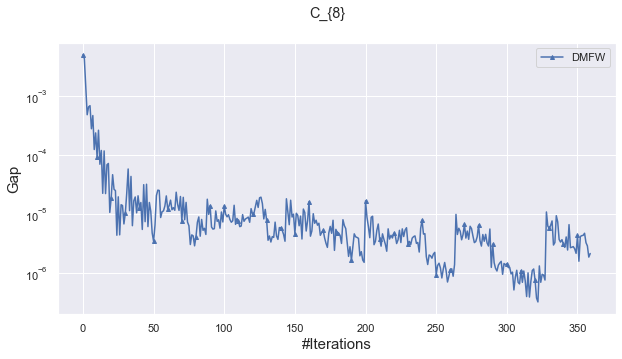

In [127]:
plt.figure(figsize=(10,5))
plt.suptitle("{}".format(cycle))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,2][:-1], label='DMFW', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-4, 1e0))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Gap",fontsize=15)

In [128]:
np.mean(values_dmfw[:,1][:-1])

0.019154353580880627

In [129]:
onlineloss = np.cumsum(values_dmfw[:,1][:-1])
arangement = np.arange(1,len(onlineloss)+1)
onlineloss = onlineloss/arangement

Text(0, 0.5, 'Loss')

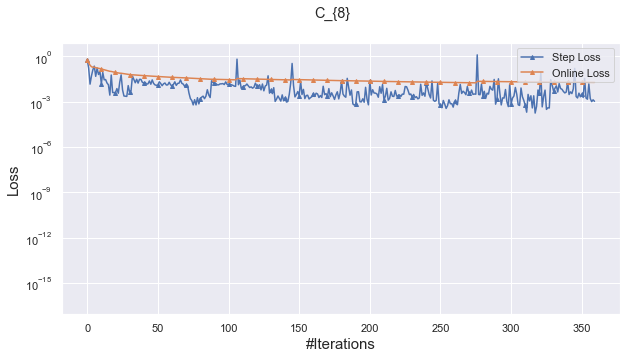

In [130]:
plt.figure(figsize=(10,5))
plt.suptitle("{}".format(cycle))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],onlineloss, label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-3, 1e2))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

# Prediction

In [131]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    #print(pred_array.shape)
    pred_shape = pred_array.shape
    #print(pred_shape)
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

In [132]:
def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_
        mini = scalers[zone_name].data_min_
        data_range = 1
        #true = ((true.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        #pred = ((pred.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        true = scalers[zone_name].inverse_transform(true.reshape(-1,1))
        pred = scalers[zone_name].inverse_transform(pred.reshape(-1,1))
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [133]:
def plotprediction(pandas): 
    plt.figure(figsize=(15,5))
    plt.title(f'{myfloor[indexroom]}')
    plt.plot(pandas["Truth"],label="Truth")
    plt.plot(pandas["Prediction"],label="Prediction",ls='-')
    plt.xticks(ticks=np.arange(pandas.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    plt.show()

In [134]:
zone_id

['Floor6Z5',
 'Floor6Z4',
 'Floor7Z4',
 'Floor7Z1',
 'Floor6Z2',
 'Floor6Z1',
 'Floor7Z5',
 'Floor7Z2']

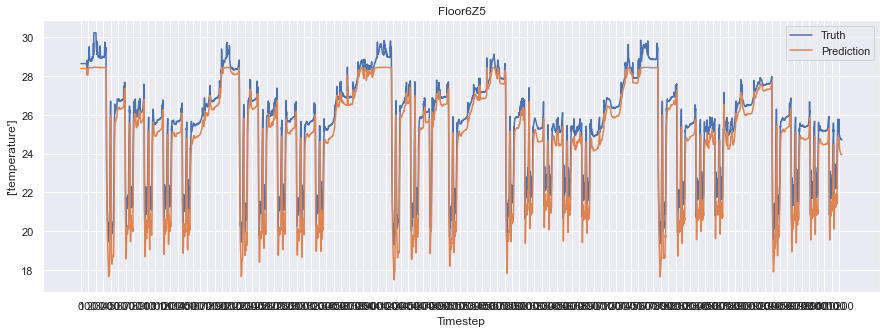

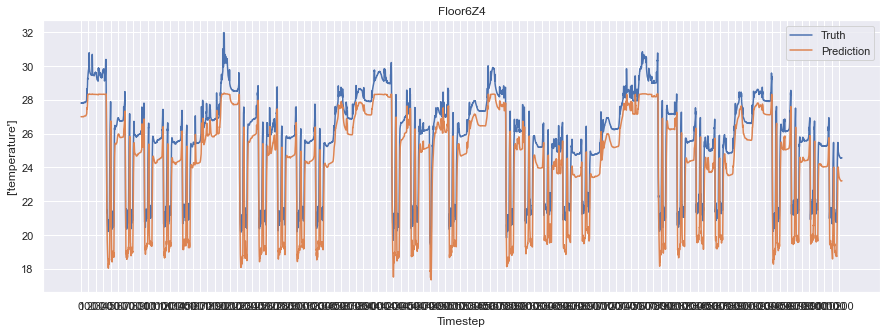

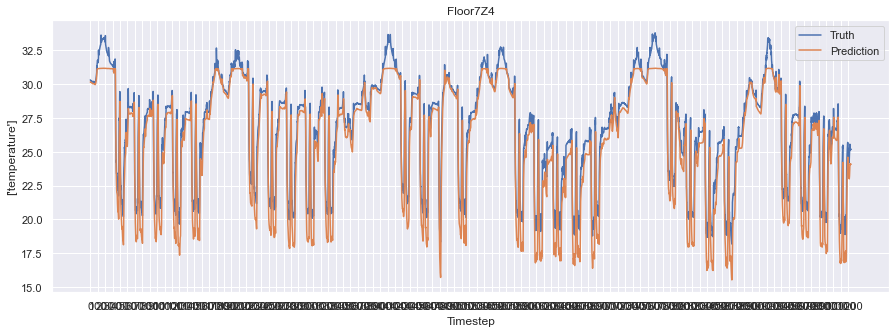

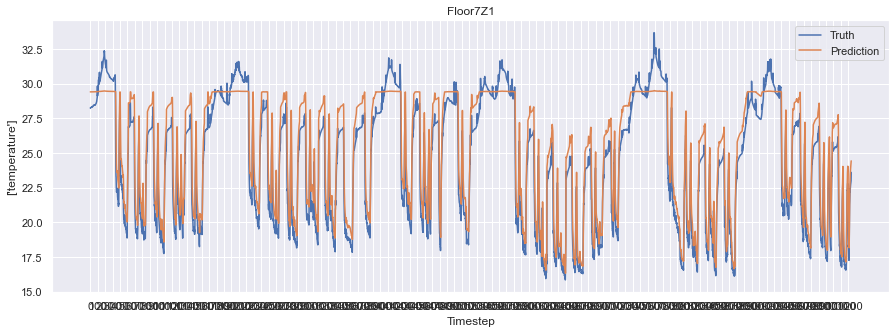

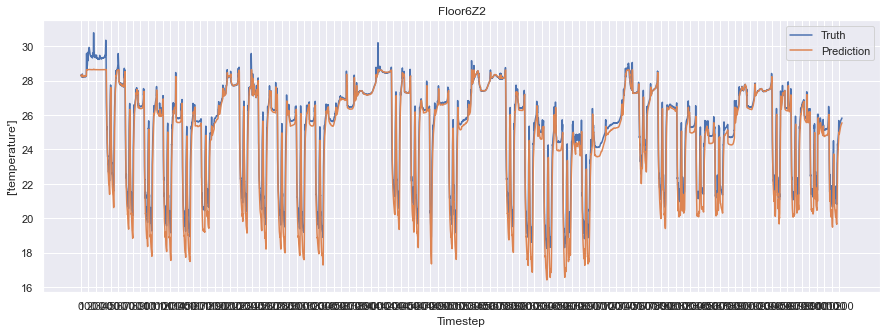

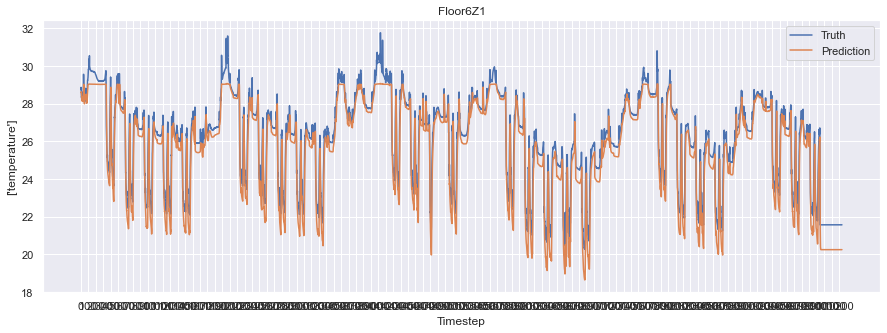

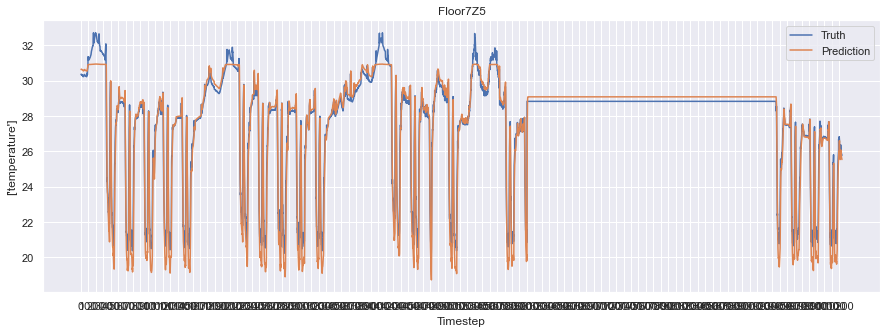

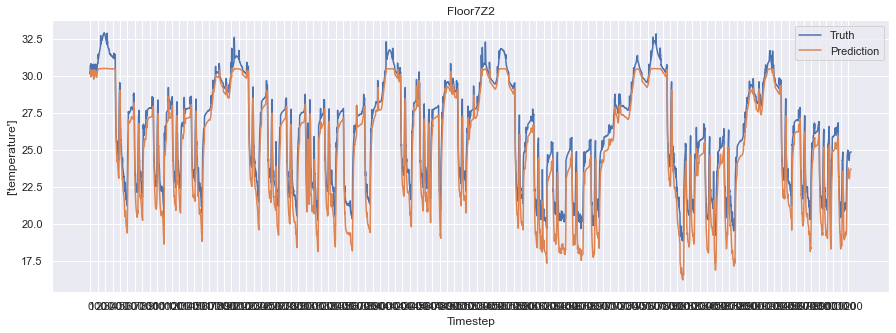

In [135]:
#real_index_zone = [1,2,4,5,1,2,4,5]
myfloor = zone_id#sorted(list(scaled_data.keys()))
may = [date for date in test_date if '2019-05' in date or "2019-04" in date]
for indexroom in range(len(trainXMFW.best_models)):
    mymodel = trainXMFW.best_models[indexroom]
    resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[-1],testloader[indexroom], lookahead, scalers,
                                     myfloor[indexroom])
    plotprediction(resultpd)
    pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-{myfloor[indexroom]}.csv')

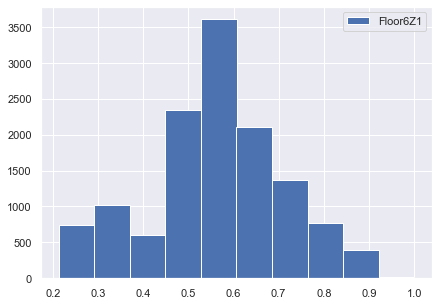

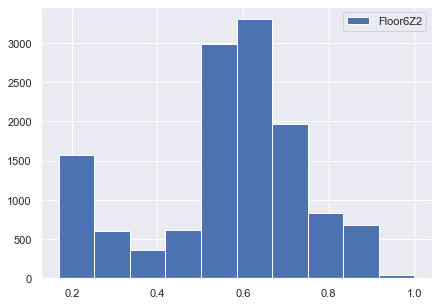

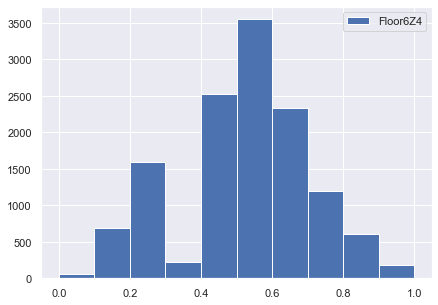

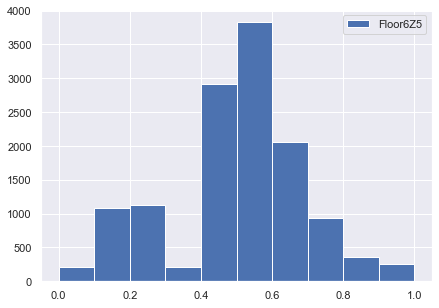

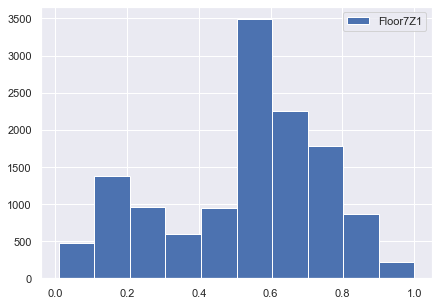

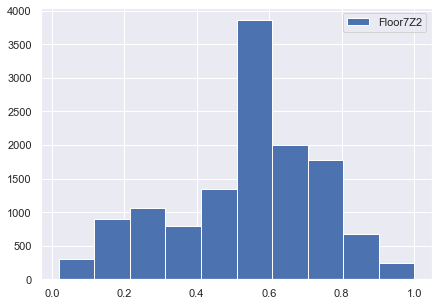

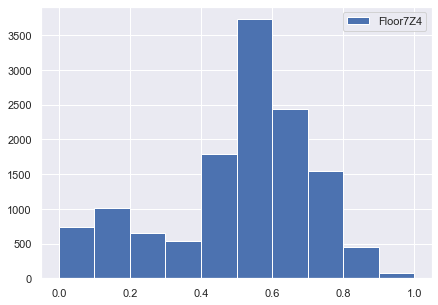

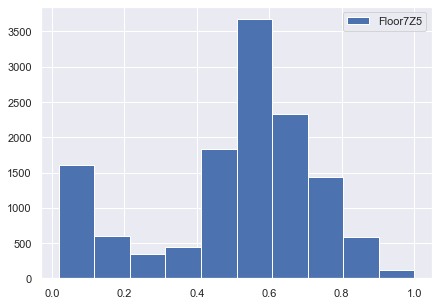

In [88]:
floor_name = sorted(list(floor_dict.keys()))
for name in floor_name:
    plt.figure(figsize=(7,5))
    plt.hist(resample[name].loc[resample[name]["date"].isin(train_date)]["temperature"],label = f'{name}')
    plt.legend()

In [52]:
np.correlate(resultpd["Truth"].values, resultpd["Prediction"].values)

array([8419867.], dtype=float32)

In [53]:
a = scaled_data["Floor7Z1"][:cutting_date]

<AxesSubplot:xlabel='Date'>

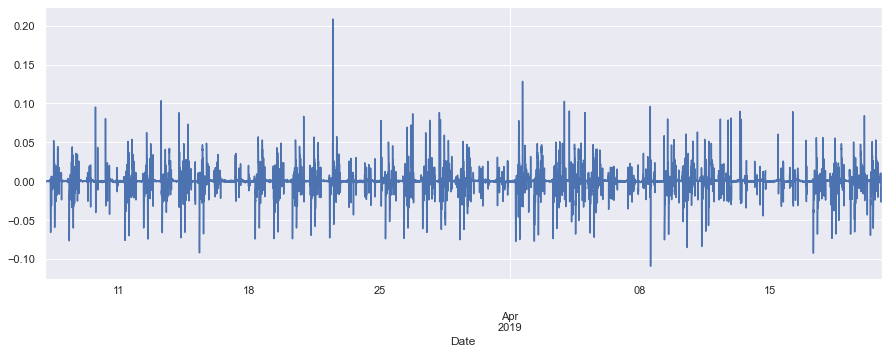

In [54]:
a["temperature"].diff()[1:].plot(figsize=(15,5))

<AxesSubplot:xlabel='Prediction', ylabel='Truth'>

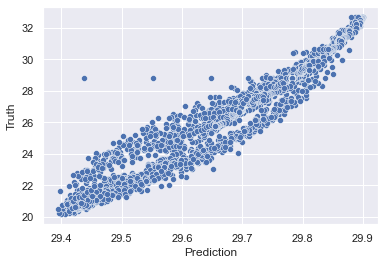

In [55]:
sns.scatterplot(x="Prediction",y="Truth",data=resultpd)